# Modeling Exercises

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pydataset import data
import acquire
import prepare

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from env import host, user, password

In [2]:
from sklearn.model_selection import train_test_split

def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test

## Decision Tree

### Using the titanic data, in your classification-exercises repository, create a notebook, model.ipynb where you will do the following:

In [3]:
from acquire import get_titanic_data

In [4]:
titanic = get_titanic_data()
titanic.head()

,Unnamed: 0,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,0,3,male,22.0,1,0,7.2500,S,Third,NaN,Southampton,0
1,1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,2,1,3,female,26.0,0,0,7.9250,S,Third,NaN,Southampton,1
3,3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,4,0,3,male,35.0,0,0,8.0500,S,Third,NaN,Southampton,1


In [5]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    891 non-null    int64  
 1   passenger_id  891 non-null    int64  
 2   survived      891 non-null    int64  
 3   pclass        891 non-null    int64  
 4   sex           891 non-null    object 
 5   age           714 non-null    float64
 6   sibsp         891 non-null    int64  
 7   parch         891 non-null    int64  
 8   fare          891 non-null    float64
 9   embarked      889 non-null    object 
 10  class         891 non-null    object 
 11  deck          203 non-null    object 
 12  embark_town   889 non-null    object 
 13  alone         891 non-null    int64  
dtypes: float64(2), int64(7), object(5)
memory usage: 97.6+ KB


In [6]:
#Preapare the data: Drop columns 
columns_to_drop = ['Unnamed: 0','pclass', 'embark_town', 'embarked', 'deck',  'parch', 'passenger_id', 'age']
titanic.drop(columns=columns_to_drop, inplace=True)

In [7]:
titanic.head()

,survived,sex,sibsp,fare,class,alone
0,0,male,1,7.2500,Third,0
1,1,female,1,71.2833,First,0
2,1,female,0,7.9250,Third,1
3,1,female,1,53.1000,First,0
4,0,male,0,8.0500,Third,1


In [8]:
#Decode survived ==> This is the target variable and targets do not need to be encoded for classification decision trees
titanic.rename(columns={'survived':"survival"}, inplace=True)
titanic['survived'] = titanic.survival.apply(lambda n: 'survived' if n > 0 else 'died')

In [9]:
#Encode Class and Sex as these are features we want to explore. The additional features of fare, alone, sibsp are already encoded. 
dummies = pd.get_dummies(titanic[['class', 'sex']], drop_first=[True])

In [10]:
#Concat dummies df with Titanic 
titanic = pd.concat([titanic, dummies], axis=1)

In [11]:
#drop additional columns after encoding
titanic.drop(columns={'sex','class','survival'}, inplace=True)

In [12]:
#split data into train, validate, and test
#stratidfy by survived 
train, validate, test = train_validate_test_split(titanic, target='survived', seed=123)

X_train = train.drop(columns=['survived'])
y_train = train.survived

X_validate = validate.drop(columns=['survived'])
y_validate = validate.survived

X_test = test.drop(columns=['survived'])
y_test = test.survived

### 1. What is your baseline prediction? What is your baseline accuracy? remember: your baseline prediction for a classification problem is predicting the most prevelant class in the training dataset (the mode). When you make those predictions, what is your accuracy? This is your baseline accuracy.

In [13]:
#target == survived
#features == sex, class, fare, alone, siblings

In [14]:
#Determine the baseline prediction by finding the mode for survived
train.survived.value_counts()

died        307
survived    191
Name: survived, dtype: int64

In [15]:
#Establish baseline prediction
train['baseline_prediction'] = 'died'

In [16]:
#Calculate baseline accuracy
baseline_accuracy = (train.baseline_prediction == train.survived).mean()
baseline_accuracy

0.6164658634538153

### 2. Fit the decision tree classifier to your training sample and transform (i.e. make predictions on the training sample)

In [17]:
#Set-up Model 1 Decision Tree with a max depth of 2
clf = DecisionTreeClassifier(max_depth=2, random_state=123)

In [18]:
#Fit the decision tree to training data
clf = clf.fit(X_train, y_train)

In [19]:
#Check labels for class names
clf.classes_

array(['died', 'survived'], dtype=object)

In [20]:
#Visualize decision tree: 

#import graphviz
#from graphviz import Graph
#
#dot_data = export_graphviz(clf, feature_names= X_train.columns, rounded=True, filled=True, out_file=None, class_names=clf.classes_)
#graph = graphviz.Source(dot_data) 
#
#graph.render('titanic_decision_tree', view=True)

In [21]:
#Peek at the first 5 predictions from model 1
y_pred = clf.predict(X_train)
y_pred[0:5]

array(['died', 'died', 'died', 'survived', 'survived'], dtype=object)

In [22]:
#Compare the predictions against the actuals
train.head()

,sibsp,fare,alone,survived,class_Second,class_Third,sex_male,baseline_prediction
583,0,40.1250,1,died,0,0,1,died
165,0,20.5250,0,survived,0,1,1,died
50,4,39.6875,0,died,0,1,1,died
259,0,26.0000,0,survived,1,0,0,died
306,0,110.8833,1,survived,0,0,0,died


In [23]:
#Calculate the probabilities for each class
y_pred_proba = clf.predict_proba(X_train)
y_pred_proba[0:5]

array([[0.68644068, 0.31355932],
       [0.68644068, 0.31355932],
       [0.68644068, 0.31355932],
       [0.04255319, 0.95744681],
       [0.04255319, 0.95744681]])

### 3. Evaluate your in-sample results using the model score, confusion matrix, and classification report.

In [24]:
#Model Score: 
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.80


In [25]:
#Evealuate with Cofusion Matrix
confusion_matrix(y_train, y_pred)

array([[265,  42],
       [ 58, 133]])

In [26]:
labels = sorted(y_train.unique())

pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

,died,survived
died,265,42
survived,58,133


In [27]:
#Evaluate with Classififcation Report
model_1_report = classification_report(y_train, y_pred)
print(model_1_report)

              precision    recall  f1-score   support

        died       0.82      0.86      0.84       307
    survived       0.76      0.70      0.73       191

    accuracy                           0.80       498
   macro avg       0.79      0.78      0.78       498
weighted avg       0.80      0.80      0.80       498



### 4. Compute: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support

In [28]:
#Accuracy
print(f'Model has an accuracy score of {accuracy_score(y_pred, y_train):.2%}')

Model has an accuracy score of 79.92%


In [29]:
#Rates from confusions matrix 
#Where dead is being treated as the positive class and survived is the negative class

sample_count = len(train)

tp = 265
fp = 58
fn = 42
tn = 133

print(f'True Positive Rate is: {tp/sample_count:.2%}')
print(f'False Positive Rate is: {fp/sample_count:.2%}')
print(f'True Negative Rate is: {tn/sample_count:.2%}')
print(f'False Negative Rate is: {fn/sample_count:.2%}')

True Positive Rate is: 53.21%
False Positive Rate is: 11.65%
True Negative Rate is: 26.71%
False Negative Rate is: 8.43%


In [30]:
#Precision
precision_score(y_train, y_pred, labels=['survived', 'died'], average=None)

array([0.76      , 0.82043344])

In [31]:
#Recall
recall_score(y_train, y_pred, labels=['survived', 'died'], average=None)

array([0.69633508, 0.86319218])

In [32]:
#f1-score
f1_score(y_train, y_pred, labels=['survived', 'died'], average=None)

array([0.72677596, 0.84126984])

In [33]:
#Support
precision_recall_fscore_support(y_train, y_pred, labels=['survived', 'died'], average=None)[3]

array([191, 307])

### 5. Run through steps 2-4 using a different max_depth value.

In [34]:
#Set-up Model 2 using a decision treet with a max depth of 3 
clf_2 = DecisionTreeClassifier(max_depth=3, random_state=123)

In [35]:
#Fit the training data to Model 2 
clf_2 = clf_2.fit(X_train, y_train)

In [36]:
#Check labels
clf_2.classes_

array(['died', 'survived'], dtype=object)

In [37]:
#Visualize the decision tree:

#dot_data = export_graphviz(clf_2, feature_names= X_train.columns, rounded=True, filled=True, out_file=None, class_names=clf_2.classes_)
#graph = graphviz.Source(dot_data) 
#
#graph.render('titanic_2_decision_tree', view=True)

In [38]:
#Peek at the first 5 predictions from model 2 
y_pred_2 = clf_2.predict(X_train)
y_pred_2[0:5]

array(['died', 'died', 'died', 'survived', 'survived'], dtype=object)

In [39]:
#Calculate the probabilities for each class
y_pred_proba = clf_2.predict_proba(X_train)
y_pred_proba[0:5]

array([[0.69827586, 0.30172414],
       [0.69827586, 0.30172414],
       [0.69827586, 0.30172414],
       [0.07142857, 0.92857143],
       [0.01923077, 0.98076923]])

#### Model 2 Evaluation

In [40]:
#Model 2 Score: 
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf_2.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.82


In [41]:
#Evealuate with Cofusion Matrix
confusion_matrix(y_train, y_pred_2)

array([[276,  31],
       [ 57, 134]])

In [42]:
labels = sorted(y_train.unique())

pd.DataFrame(confusion_matrix(y_train, y_pred_2), index=labels, columns=labels)

,died,survived
died,276,31
survived,57,134


In [43]:
model_2_report = classification_report(y_train, y_pred_2)

In [44]:
print(model_2_report)

              precision    recall  f1-score   support

        died       0.83      0.90      0.86       307
    survived       0.81      0.70      0.75       191

    accuracy                           0.82       498
   macro avg       0.82      0.80      0.81       498
weighted avg       0.82      0.82      0.82       498



### 6. Which model performs better on your in-sample data?

### Takeaway: ***Model 2 performs better on in-sample data***

In [45]:
print(model_1_report, model_2_report)

              precision    recall  f1-score   support

        died       0.82      0.86      0.84       307
    survived       0.76      0.70      0.73       191

    accuracy                           0.80       498
   macro avg       0.79      0.78      0.78       498
weighted avg       0.80      0.80      0.80       498
               precision    recall  f1-score   support

        died       0.83      0.90      0.86       307
    survived       0.81      0.70      0.75       191

    accuracy                           0.82       498
   macro avg       0.82      0.80      0.81       498
weighted avg       0.82      0.82      0.82       498



### 7. Which model performs best on your out-of-sample data, the validate set?

### Takeaway: ***Model 2 performs better on the out-of-sample data***

#### Evaluate Model 1 on out-of-sample data

In [46]:
#Model 1 Accuracy for Validate Data set
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf.score(X_validate, y_validate)))

Accuracy of Decision Tree classifier on validate set: 0.76


In [47]:
y_pred = clf.predict(X_validate)

In [48]:
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

        died       0.80      0.83      0.81       132
    survived       0.70      0.66      0.68        82

    accuracy                           0.76       214
   macro avg       0.75      0.74      0.74       214
weighted avg       0.76      0.76      0.76       214



#### Evaluate Model 2 on out-of-sample data

In [49]:
# Model 2 Accuracy for Validate Data set
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf_2.score(X_validate, y_validate)))

Accuracy of Decision Tree classifier on validate set: 0.79


In [50]:
y_pred_2 = clf_2.predict(X_validate)

In [51]:
print(classification_report(y_validate, y_pred_2))

              precision    recall  f1-score   support

        died       0.80      0.87      0.83       132
    survived       0.76      0.65      0.70        82

    accuracy                           0.79       214
   macro avg       0.78      0.76      0.77       214
weighted avg       0.78      0.79      0.78       214



## Random Forest Exercises

In [52]:
from sklearn.ensemble import RandomForestClassifier

In [53]:
# split into train, validate, test
train, validate, test = train_validate_test_split(titanic, target='survived', seed=123)

# create X & y version of train, where y is a series with just the target variable and X are all the features. 

X_train = train.drop(columns=['survived'])
y_train = train.survived

X_validate = validate.drop(columns=['survived'])
y_validate = validate.survived

X_test = test.drop(columns=['survived'])
y_test = test.survived

In [54]:
train.head()

,sibsp,fare,alone,survived,class_Second,class_Third,sex_male
583,0,40.1250,1,died,0,0,1
165,0,20.5250,0,survived,0,1,1
50,4,39.6875,0,died,0,1,1
259,0,26.0000,0,survived,1,0,0
306,0,110.8833,1,survived,0,0,0


### 1. Fit the Random Forest classifier to your training sample and transform (i.e. make predictions on the training sample) setting the random_state accordingly and setting min_samples_leaf = 1 and max_depth = 10.

In [55]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=1,
                            n_estimators=100,
                            max_depth=10, 
                            random_state=123)

In [56]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=123)

In [57]:
y_pred = rf.predict(X_train)

In [58]:
y_pred_proba = rf.predict_proba(X_train)

### 2. Evaluate your results using the model score, confusion matrix, and classification report.

In [59]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.94


In [60]:
conf_matrix = (confusion_matrix(y_train, y_pred))
conf_df = pd.DataFrame(conf_matrix, columns=['predict_death', 'predict_survive'], index=['actual_death', 'actual_survive'])
rubric_df = pd.DataFrame([['true positive', 'false negative'],['false positive', 'true negative']], columns=['predict_death', 'predict_survive'], index=['actual_death', 'actual_survive'])
joined = pd.concat([conf_df, rubric_df], axis=1)
joined

,predict_death,predict_survive,predict_death,predict_survive
actual_death,300,7,true positive,false negative
actual_survive,23,168,false positive,true negative


In [61]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

        died       0.93      0.98      0.95       307
    survived       0.96      0.88      0.92       191

    accuracy                           0.94       498
   macro avg       0.94      0.93      0.94       498
weighted avg       0.94      0.94      0.94       498



### 3. Print and clearly label the following: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

In [13]:
def get_metrics_binary(clf):
    '''
    get_metrics_binary takes in a confusion matrix (cnf) for a binary classifier and prints out metrics based on
    values in variables named X_train, y_train, and y_pred.
    
    return: a classification report as a transposed DataFrame
    '''
    #accuracy = clf.score(X_train, y_train)
    class_report = pd.DataFrame(classification_report(y_train, y_pred, output_dict=True)).T
    clf = confusion_matrix(y_train, y_pred)
    tpr = clf[0][0] / clf[0].sum()
    fpr = clf[0][1] / clf[1].sum()
    tnr = clf[1][1] / clf[1].sum()
    fnr = clf[1][0] / clf[0].sum()
    print(f'''
    Confusion Matrix: \n {clf},
    '--------------------------------',
    The True Positive Rate is {tpr:.2}, The False Positive Rate is {fpr:.2},
    The True Negative Rate is {tnr:.2}, and the False Negative Rate is {fnr:.2}
    ''')
    return class_report

In [63]:
rf_model1_report = get_metrics_binary(conf_df)
rf_model1_report


    The True Positive Rate is 0.98, The False Positive Rate is 0.037,
    The True Negative Rate is 0.88, and the False Negative Rate is 0.075
    


,precision,recall,f1-score,support
died,0.928793,0.977199,0.952381,307.000000
survived,0.960000,0.879581,0.918033,191.000000
accuracy,0.939759,0.939759,0.939759,0.939759
macro avg,0.944396,0.928390,0.935207,498.000000
weighted avg,0.940762,0.939759,0.939207,498.000000


### 4. Run through steps increasing your min_samples_leaf and decreasing your max_depth.

In [64]:
#Random Forest Model 2 with increased min_samples_leaf and decreased mx_depth
rf_2 = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=2,
                            n_estimators=100,
                            max_depth=4, 
                            random_state=123)

In [65]:
#Fit the training data to random forest model 2
rf_2.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, min_samples_leaf=2, random_state=123)

In [66]:
#Set the y_pred
y_pred = rf_2.predict(X_train)

#### Evaluate Model 2

In [67]:
#Return accuracy metric for random forest model 2
print('Model 2 Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf_2.score(X_train, y_train)))

Model 2 Accuracy of random forest classifier on training set: 0.84


In [68]:
#Set the confusion matrix for model 2...treat death as the positive class
conf_matrix = (confusion_matrix(y_train, y_pred))
conf_df = pd.DataFrame(conf_matrix, columns=['predict_death', 'predict_survive'], index=['actual_death', 'actual_survive'])

In [69]:
#Return metrics report for evaluating model 2 
rf_model2_report = get_metrics_binary(conf_df)
rf_model2_report


    The True Positive Rate is 0.94, The False Positive Rate is 0.099,
    The True Negative Rate is 0.68, and the False Negative Rate is 0.2
    


,precision,recall,f1-score,support
died,0.822857,0.938111,0.876712,307.000000
survived,0.871622,0.675393,0.761062,191.000000
accuracy,0.837349,0.837349,0.837349,0.837349
macro avg,0.847239,0.806752,0.818887,498.000000
weighted avg,0.841560,0.837349,0.832356,498.000000


### 5. What are the differences in the evaluation metrics? Which performs better on your in-sample data? Why?

In [70]:
print(f'Model 1 Random Forest Metrics: \n\n {rf_model1_report:}')
print('--------------------------------------')
print(f'Model 2 Random Forest Metrics: \n\n {rf_model2_report:}')

Model 1 Random Forest Metrics: 

               precision    recall  f1-score     support
died           0.928793  0.977199  0.952381  307.000000
survived       0.960000  0.879581  0.918033  191.000000
accuracy       0.939759  0.939759  0.939759    0.939759
macro avg      0.944396  0.928390  0.935207  498.000000
weighted avg   0.940762  0.939759  0.939207  498.000000
--------------------------------------
Model 2 Random Forest Metrics: 

               precision    recall  f1-score     support
died           0.822857  0.938111  0.876712  307.000000
survived       0.871622  0.675393  0.761062  191.000000
accuracy       0.837349  0.837349  0.837349    0.837349
macro avg      0.847239  0.806752  0.818887  498.000000
weighted avg   0.841560  0.837349  0.832356  498.000000


### 6. After making a few models, which one has the best performance (or closest metrics) on both train and validate?

In [71]:
#Random Forest Model 3 with increased min_samples_leaf and decreased mx_depth
rf_3 = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=10,
                            n_estimators=100,
                            max_depth=8, 
                            random_state=123)

In [72]:
rf_3.fit(X_train, y_train)
y_pred = rf_3.predict(X_train)

In [73]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf_3.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.83


In [74]:
conf_matrix = (confusion_matrix(y_train, y_pred))
conf_df = pd.DataFrame(conf_matrix, columns=['predict_death', 'predict_survive'], index=['actual_death', 'actual_survive'])

In [75]:
rf_model3_report = get_metrics_binary(conf_matrix)
rf_model3_report


    The True Positive Rate is 0.95, The False Positive Rate is 0.084,
    The True Negative Rate is 0.63, and the False Negative Rate is 0.23
    


,precision,recall,f1-score,support
died,0.806094,0.947883,0.871257,307.000000
survived,0.883212,0.633508,0.737805,191.000000
accuracy,0.827309,0.827309,0.827309,0.827309
macro avg,0.844653,0.790695,0.804531,498.000000
weighted avg,0.835671,0.827309,0.820074,498.000000


### Takeaway: ***Random Forest Model 1 performs the best on the training data set***

#### Evaluate the models with out of sample data set

In [76]:
y_pred = rf.predict(X_validate)
print('Model 1 Accuracy of random forest classifier on validate set: {:.2f}'
     .format(rf.score(X_validate, y_validate)))

print('------------')
y_pred = rf_2.predict(X_validate)
print('Model 2 Accuracy of random forest classifier on validate set: {:.2f}'
     .format(rf_2.score(X_validate, y_validate)))

print('------------')
y_pred = rf_3.predict(X_validate)
print('Model 3 Accuracy of random forest classifier on validate set: {:.2f}'
     .format(rf_3.score(X_validate, y_validate)))

Model 1 Accuracy of random forest classifier on validate set: 0.78
------------
Model 2 Accuracy of random forest classifier on validate set: 0.79
------------
Model 3 Accuracy of random forest classifier on validate set: 0.79


### Takeaway: ***Random Forest Model 1 performs better on the validate data set***

## KNN Exercises

### 1. Fit a K-Nearest Neighbors classifier to your training sample and transform (i.e. make predictions on the training sample)

In [14]:
#Confirm training data set is good to work with
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 498 entries, 583 to 744
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sibsp         498 non-null    int64  
 1   fare          498 non-null    float64
 2   alone         498 non-null    int64  
 3   survived      498 non-null    object 
 4   class_Second  498 non-null    uint8  
 5   class_Third   498 non-null    uint8  
 6   sex_male      498 non-null    uint8  
dtypes: float64(1), int64(2), object(1), uint8(3)
memory usage: 20.9+ KB


In [18]:
#Create a KNN model with k=5
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [19]:
#Fit the model to the training data without limiting the dimensions (using all features for this model)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [20]:
#Make predictions
y_pred = knn.predict(X_train)

In [21]:
#Estimate the probability for each class (died, survived)
y_pred_proba = knn.predict_proba(X_train)
y_pred_proba

array([[0.8, 0.2],
       [0.6, 0.4],
       [0.6, 0.4],
       [0.2, 0.8],
       [0.4, 0.6],
       [0.6, 0.4],
       [0.8, 0.2],
       [0.8, 0.2],
       [1. , 0. ],
       [1. , 0. ],
       [0.6, 0.4],
       [0.6, 0.4],
       [0.2, 0.8],
       [1. , 0. ],
       [0.8, 0.2],
       [1. , 0. ],
       [1. , 0. ],
       [0.2, 0.8],
       [1. , 0. ],
       [0.6, 0.4],
       [0. , 1. ],
       [1. , 0. ],
       [0.2, 0.8],
       [0.2, 0.8],
       [0.6, 0.4],
       [1. , 0. ],
       [0. , 1. ],
       [0.6, 0.4],
       [0.4, 0.6],
       [1. , 0. ],
       [1. , 0. ],
       [0.8, 0.2],
       [1. , 0. ],
       [0. , 1. ],
       [0.2, 0.8],
       [0.8, 0.2],
       [1. , 0. ],
       [0. , 1. ],
       [0.8, 0.2],
       [0. , 1. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [0.6, 0.4],
       [0.6, 0.4],
       [0.8, 0.2],
       [1. , 0. ],
       [0.8, 0.2],
       [0.2, 0.8],
       [0.6, 0.4],
       [0.8, 0.2],
       [0.8, 0.2],
       [0.2,

### 2. Evaluate your results using the model score, confusion matrix, and classification report.

In [121]:
get_metrics_binary(knn)


    Confusion Matrix: 
 [[265  42]
 [ 47 144]],
    '--------------------------------',
    The True Positive Rate is 0.86, The False Positive Rate is 0.22,
    The True Negative Rate is 0.75, and the False Negative Rate is 0.15
    


,precision,recall,f1-score,support
died,0.849359,0.863192,0.856220,307.000000
survived,0.774194,0.753927,0.763926,191.000000
accuracy,0.821285,0.821285,0.821285,0.821285
macro avg,0.811776,0.808559,0.810073,498.000000
weighted avg,0.820530,0.821285,0.820822,498.000000


### 3. Print and clearly label the following: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

In [122]:
model_1_report = get_metrics_binary(knn)
model_1_report


    Confusion Matrix: 
 [[265  42]
 [ 47 144]],
    '--------------------------------',
    The True Positive Rate is 0.86, The False Positive Rate is 0.22,
    The True Negative Rate is 0.75, and the False Negative Rate is 0.15
    


,precision,recall,f1-score,support
died,0.849359,0.863192,0.856220,307.000000
survived,0.774194,0.753927,0.763926,191.000000
accuracy,0.821285,0.821285,0.821285,0.821285
macro avg,0.811776,0.808559,0.810073,498.000000
weighted avg,0.820530,0.821285,0.820822,498.000000


### 4. Run through steps 2-4 setting k to 10

In [123]:
#Create a KNN model with k set to 10 
knn_2 = KNeighborsClassifier(n_neighbors=10, weights='uniform')

In [124]:
#Fit the model to the training data
knn_2.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [125]:
#Make predictions
y_pred = knn_2.predict(X_train)

In [126]:
#Estimate the probability for each class (died, survived)
y_pred_proba = knn_2.predict_proba(X_train)

In [127]:
#Evaluate KNN Model 2
model_2_report = get_metrics_binary(knn_2)
model_2_report


    Confusion Matrix: 
 [[266  41]
 [ 57 134]],
    '--------------------------------',
    The True Positive Rate is 0.87, The False Positive Rate is 0.21,
    The True Negative Rate is 0.7, and the False Negative Rate is 0.19
    


,precision,recall,f1-score,support
died,0.823529,0.866450,0.844444,307.000000
survived,0.765714,0.701571,0.732240,191.000000
accuracy,0.803213,0.803213,0.803213,0.803213
macro avg,0.794622,0.784010,0.788342,498.000000
weighted avg,0.801355,0.803213,0.801410,498.000000


### 5. Run through setps 2-4 setting k to 20

In [128]:
#Create a KNN model with k set to 20 
knn_3 = KNeighborsClassifier(n_neighbors=20, weights='uniform')

In [129]:
#Fit the model to the training data
knn_3.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=20)

In [130]:
#Make predictions
y_pred = knn_3.predict(X_train)

In [131]:
#Estimate the probability for each class (died, survived)
y_pred_proba = knn_3.predict_proba(X_train)

In [132]:
#Evaluate KNN Model 3
model_3_report = get_metrics_binary(knn_3)
model_3_report


    Confusion Matrix: 
 [[258  49]
 [ 75 116]],
    '--------------------------------',
    The True Positive Rate is 0.84, The False Positive Rate is 0.26,
    The True Negative Rate is 0.61, and the False Negative Rate is 0.24
    


,precision,recall,f1-score,support
died,0.774775,0.840391,0.806250,307.000000
survived,0.703030,0.607330,0.651685,191.000000
accuracy,0.751004,0.751004,0.751004,0.751004
macro avg,0.738903,0.723860,0.728968,498.000000
weighted avg,0.747258,0.751004,0.746969,498.000000


### 6. What are the differences in the evaluation metrics? Which performs better on your in-sample data? Why?

In [133]:
model_1_report, model_2_report, model_3_report

(              precision    recall  f1-score     support
 died           0.849359  0.863192  0.856220  307.000000
 survived       0.774194  0.753927  0.763926  191.000000
 accuracy       0.821285  0.821285  0.821285    0.821285
 macro avg      0.811776  0.808559  0.810073  498.000000
 weighted avg   0.820530  0.821285  0.820822  498.000000,
               precision    recall  f1-score     support
 died           0.823529  0.866450  0.844444  307.000000
 survived       0.765714  0.701571  0.732240  191.000000
 accuracy       0.803213  0.803213  0.803213    0.803213
 macro avg      0.794622  0.784010  0.788342  498.000000
 weighted avg   0.801355  0.803213  0.801410  498.000000,
               precision    recall  f1-score     support
 died           0.774775  0.840391  0.806250  307.000000
 survived       0.703030  0.607330  0.651685  191.000000
 accuracy       0.751004  0.751004  0.751004    0.751004
 macro avg      0.738903  0.723860  0.728968  498.000000
 weighted avg   0.747258  0.7

### ***Takeaways:*** ###
- Analysis applies only to in-sample data
- All models beat the baseline precidiction model 
- Model 1 is the best model in terms of accuracy, 82%
- Model 2 performs slightly worse than Model 1, but Accuracy drops off the most for model 3
- It makes sense that the models with the smaller K perform better than the models with higher k values.

### 7. Which model performs best on our out-of-sample data from validate?

In [139]:
print('Model 1 Accuracy of KNN classifier on test set with k=5: {:.2f}'
     .format(knn.score(X_validate, y_validate)))
print('-------------------------------------------\nModel 2 Accuracy of KNN classifier on test set with k=10: {:.2f}'
     .format(knn_2.score(X_validate, y_validate)))
print('-------------------------------------------\nModel 3 Accuracy of KNN classifier on test set with k=20: {:.2f}\n'
     .format(knn_3.score(X_validate, y_validate)))

Model 1 Accuracy of KNN classifier on test set with k=5: 0.73
-------------------------------------------
Model 2 Accuracy of KNN classifier on test set with k=10: 0.74
-------------------------------------------
Model 3 Accuracy of KNN classifier on test set with k=20: 0.68



### Takeaway: Model 2 performs slightly better in terms of accuracy on the out-of-sample data

#### Bonus: Try a KNN model where you limit the dimensionality of the Titanic Data set:

In [22]:
#Create a KNN model with k set to 5 
knn_4 = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [25]:
#Fit the model to the training data and limit the dimensionality to 2 features
knn_4.fit(X_train[['sex_male','fare']], y_train)

KNeighborsClassifier()

In [26]:
#Make predictions
y_pred = knn_4.predict(X_train[['sex_male','fare']])

In [27]:
#Estimate the probability for each class (died, survived)
y_pred_proba = knn_4.predict_proba(X_train[['sex_male','fare']])

In [28]:
#Evaluate KNN Model 4
model_4_report = get_metrics_binary(knn_4)
model_4_report


    Confusion Matrix: 
 [[265  42]
 [ 50 141]],
    '--------------------------------',
    The True Positive Rate is 0.86, The False Positive Rate is 0.22,
    The True Negative Rate is 0.74, and the False Negative Rate is 0.16
    


,precision,recall,f1-score,support
died,0.841270,0.863192,0.852090,307.000000
survived,0.770492,0.738220,0.754011,191.000000
accuracy,0.815261,0.815261,0.815261,0.815261
macro avg,0.805881,0.800706,0.803050,498.000000
weighted avg,0.814124,0.815261,0.814473,498.000000


#### How does Model 4 perform on out of sample data?

In [30]:
print('Model 4 Accuracy of KNN classifier on validate(out of sample data set) with k=5: {:.2f}'
     .format(knn_4.score(X_validate[['sex_male','fare']], y_validate)))

Model 4 Accuracy of KNN classifier on validate(out of sample data set) with k=5: 0.75


## Logistic Regression Exercises

In these exercises, we'll continue working with the titanic dataset and building logistic regression models. Throughout this exercise, be sure you are training, evaluation, and comparing models on the train and validate datasets. The test dataset should only be used for your final model.

For all of the models you create, choose a threshold that optimizes for accuracy.

Do your work for these exercises in either a notebook or a python script named model within your classification-exercises repository. Add, commit, and push your work.


In [31]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from env import host, user, password
import acquire
import prepare

### 1. Create a model that includes age in addition to fare and pclass. Does this model perform better than your baseline?

In [44]:
from acquire import get_titanic_data

In [45]:
titanic = get_titanic_data()

In [46]:
#Preapare the data: Drop columns 
columns_to_drop = ['Unnamed: 0', 'embark_town', 'embarked', 'deck',  'parch', 'passenger_id', 'class']
titanic.drop(columns=columns_to_drop, inplace=True)

In [48]:
#encode the feature "sex"
df = pd.get_dummies(titanic[['sex']], drop_first=[True])

In [49]:
#Concat dummies df with Titanic and drop the original coloumn sex
titanic = pd.concat([titanic, dummies], axis=1).drop(columns='sex')

In [50]:
titanic.head()

,survived,pclass,age,sibsp,fare,alone,class_Second,class_Third,sex_male
0,0,3,22.0,1,7.2500,0,0,1,1
1,1,1,38.0,1,71.2833,0,0,0,0
2,1,3,26.0,0,7.9250,1,0,1,0
3,1,1,35.0,1,53.1000,0,0,0,0
4,0,3,35.0,0,8.0500,1,0,1,1


In [51]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   survived      891 non-null    int64  
 1   pclass        891 non-null    int64  
 2   age           714 non-null    float64
 3   sibsp         891 non-null    int64  
 4   fare          891 non-null    float64
 5   alone         891 non-null    int64  
 6   class_Second  891 non-null    uint8  
 7   class_Third   891 non-null    uint8  
 8   sex_male      891 non-null    uint8  
dtypes: float64(2), int64(4), uint8(3)
memory usage: 44.5 KB


#### To determine how to best deal with missing age values:
- How many observations are missing age?
    - Do the observations missing age have other features in common that could assist with filling those values?
    - Should I fill missing values or drop those observations? 
- What does the distribution of age look like?
- Is there a relationship between age and the number of siblings?
    - If you had a sibling on the Titanic, were you more likely to be a child? 

<AxesSubplot:xlabel='age', ylabel='Count'>

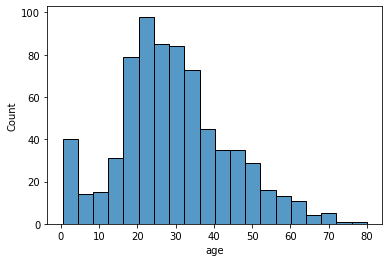

In [82]:
#Visualize the distribution of age
sns.histplot(titanic.age[titanic.age.notnull()])

In [83]:
#How many nulls in age: 
null_age = titanic.age.isnull().sum()
null_age

177

In [84]:
#What % of the observations are missing age?
null_age/len(titanic)

0.19865319865319866

In [74]:
#Filter all the passengers with missing ages for exploration
passengers_no_age = titanic[titanic.age.isnull()]
passengers_no_age.head()

,survived,pclass,age,sibsp,fare,alone,class_Second,class_Third,sex_male
5,0,3,NaN,0,8.4583,1,0,1,1
17,1,2,NaN,0,13.0000,1,1,0,1
19,1,3,NaN,0,7.2250,1,0,1,0
26,0,3,NaN,0,7.2250,1,0,1,1
28,1,3,NaN,0,7.8792,1,0,1,0


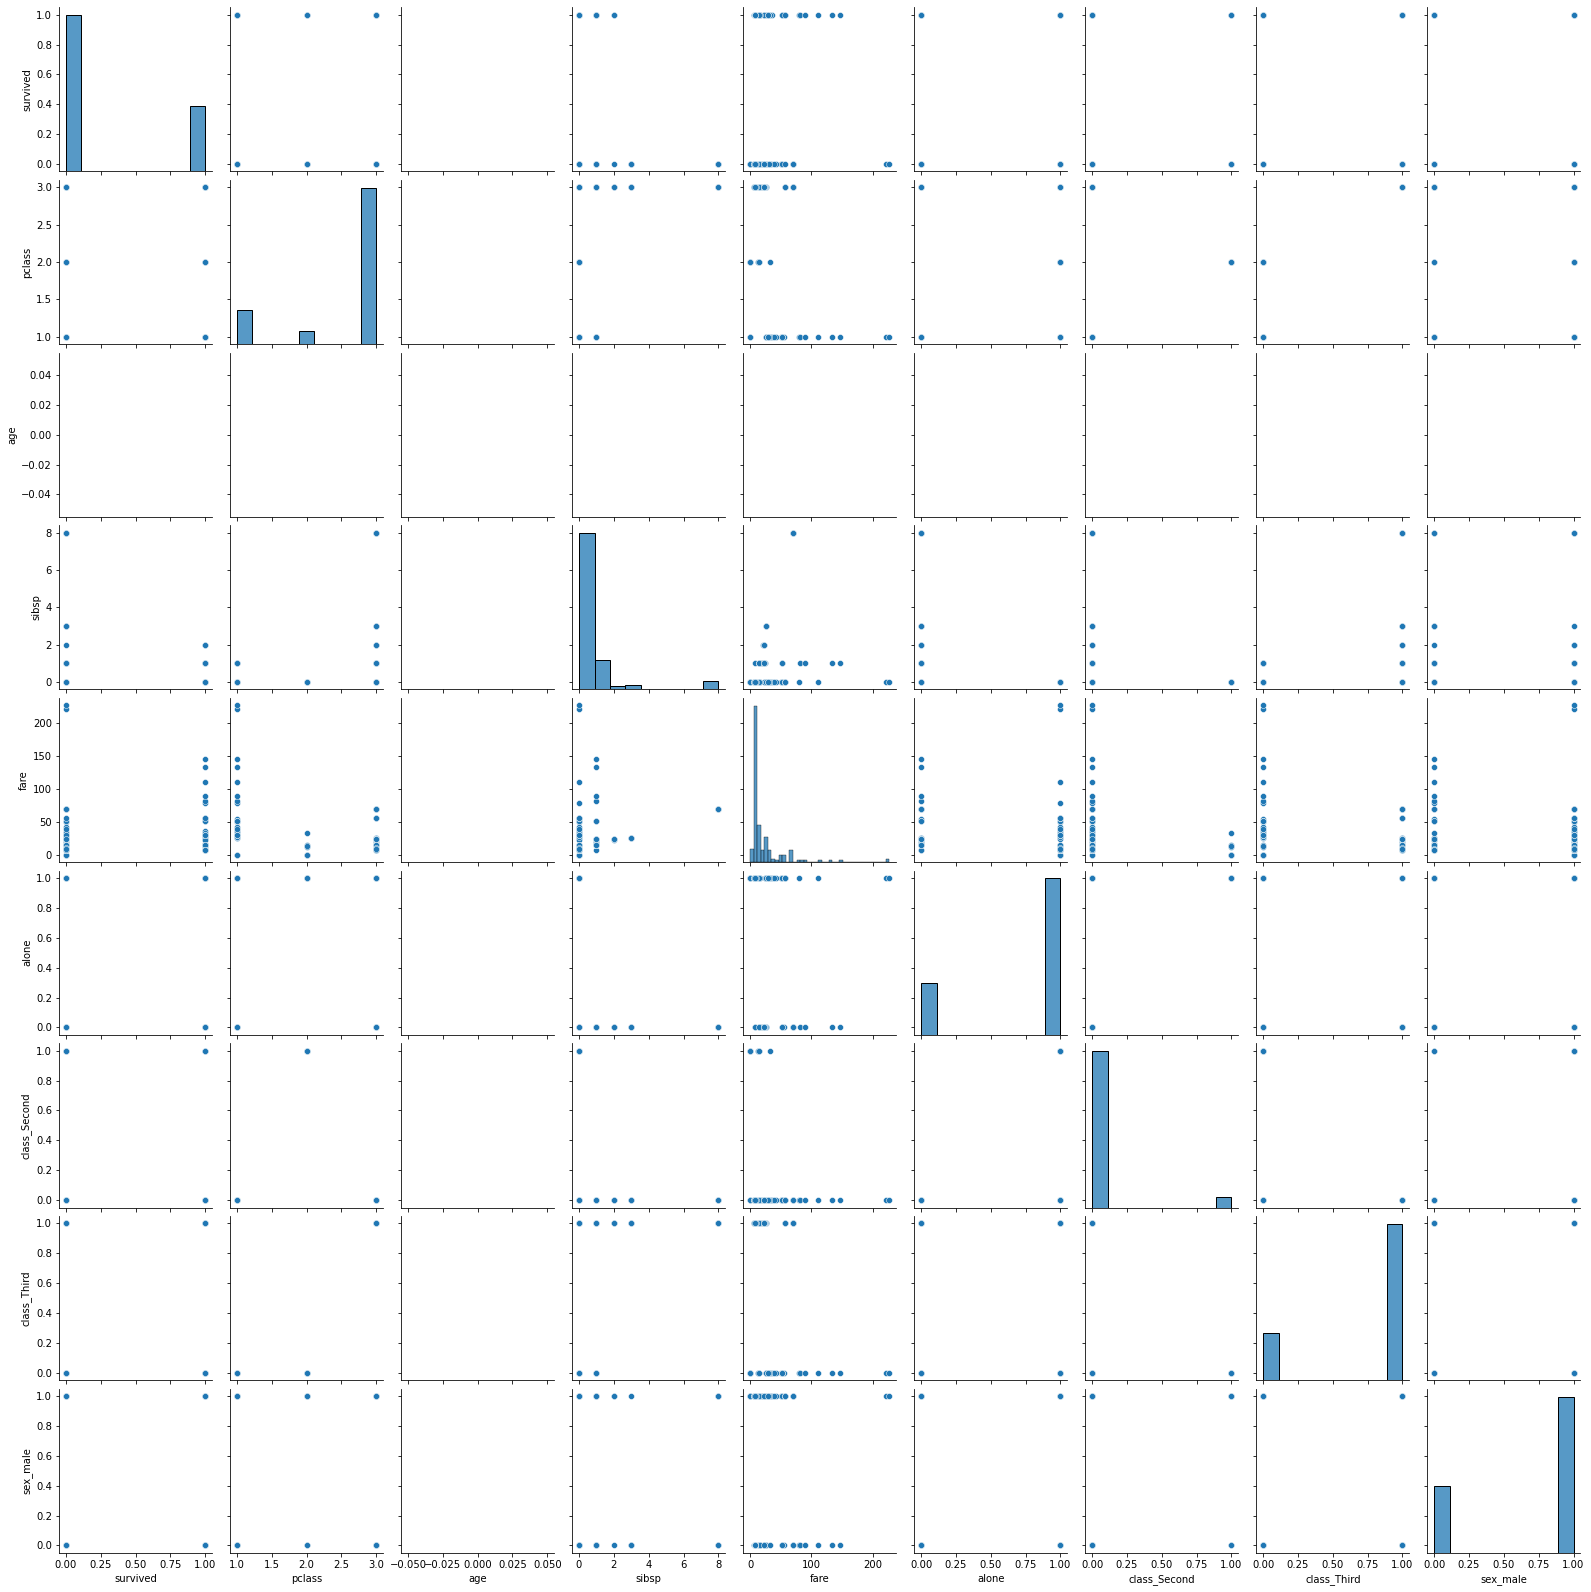

In [77]:
#Visuaize the features for those passengers with missing ages
sns.pairplot(data=passengers_no_age)

#### Takeaways for passengers with no documented ages: 
- Of those with missing ages, 2x as likely to die 
- Majority with no documented age were in 3rd class
- Most did not have any siblings
- 2/3 travelled alone
- 2x were males


In [78]:
#Population stats for passengers' ages with at least 1 siblings
titanic.age[titanic.sibsp > 0].describe()

count    243.000000
mean      26.407078
std       15.603758
min        0.670000
25%       16.000000
50%       26.000000
75%       37.000000
max       70.000000
Name: age, dtype: float64

In [79]:
#Population stats for passengers' ages that did not have any siblings
titanic.age[titanic.sibsp == 0].describe()

count    471.000000
mean      31.397558
std       13.647767
min        0.420000
25%       22.000000
50%       29.000000
75%       39.000000
max       80.000000
Name: age, dtype: float64

#### Age Decision Time:
- Because there is not enough evudence from other festures to infer a best age imputer, I will drop all rows and onbservations with missing ages.
- This will result in a 20% loss of obersevations, but I am under the assumption that less data here will be less impactful on the model than incorrect data. 

In [105]:
#Drop observations with missing age
titanic = titanic[titanic.age.notnull()]
titanic.head()

,survived,pclass,age,sibsp,fare,alone,class_Second,class_Third,sex_male
0,0,3,22.0,1,7.2500,0,0,1,1
1,1,1,38.0,1,71.2833,0,0,0,0
2,1,3,26.0,0,7.9250,1,0,1,0
3,1,1,35.0,1,53.1000,0,0,0,0
4,0,3,35.0,0,8.0500,1,0,1,1


In [87]:
#split data into train, validate, and test
#stratidfy by survived 
train, validate, test = train_validate_test_split(titanic, target='survived', seed=123)

X_train = train.drop(columns=['survived'])
y_train = train.survived

X_validate = validate.drop(columns=['survived'])
y_validate = validate.survived

X_test = test.drop(columns=['survived'])
y_test = test.survived

In [106]:
train.head()

,survived,pclass,age,sibsp,fare,alone,class_Second,class_Third,sex_male
652,0,3,21.0,0,8.4333,1,0,1,1
813,0,3,6.0,4,31.2750,0,0,1,0
194,1,1,44.0,0,27.7208,1,0,0,0
417,1,2,18.0,0,13.0000,0,1,0,0
460,1,1,48.0,0,26.5500,1,0,0,1


In [162]:
#Create the object
logit = LogisticRegression(C=1, class_weight=None, random_state=123, intercept_scaling=1, solver='lbfgs')

In [163]:
#Fit the train data set to the model
logit.fit(X_train[['age','fare','pclass']], y_train)

LogisticRegression(C=1, random_state=123)

In [164]:
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

Coefficient: 
 [[-0.04138191  0.00146339 -1.19226315]]
Intercept: 
 [3.42691873]


In [165]:
y_pred = logit.predict(X_train[['age','fare','pclass']])
y_pred

array([0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,

In [166]:
y_pred_proba = logit.predict_proba(X_train[['age','fare','pclass']])
y_pred_proba

array([[0.73234435, 0.26765565],
       [0.58719813, 0.41280187],
       [0.38831084, 0.61168916],
       [0.42151867, 0.57848133],
       [0.42869509, 0.57130491],
       [0.63028828, 0.36971172],
       [0.60092194, 0.39907806],
       [0.73249013, 0.26750987],
       [0.42697976, 0.57302024],
       [0.55411812, 0.44588188],
       [0.87212214, 0.12787786],
       [0.60785499, 0.39214501],
       [0.28485315, 0.71514685],
       [0.7158947 , 0.2841053 ],
       [0.63603063, 0.36396937],
       [0.52521243, 0.47478757],
       [0.54512485, 0.45487515],
       [0.87641324, 0.12358676],
       [0.299683  , 0.700317  ],
       [0.66175815, 0.33824185],
       [0.49328319, 0.50671681],
       [0.50769458, 0.49230542],
       [0.81021521, 0.18978479],
       [0.84243401, 0.15756599],
       [0.59385051, 0.40614949],
       [0.2327083 , 0.7672917 ],
       [0.95503888, 0.04496112],
       [0.33124381, 0.66875619],
       [0.24646001, 0.75353999],
       [0.24378441, 0.75621559],
       [0.

In [167]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train[['age','fare','pclass']], y_train)))

Accuracy of Logistic Regression classifier on training set: 0.70


In [168]:
print(confusion_matrix(y_train, y_pred))

[[194  43]
 [ 77  85]]


In [169]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.82      0.76       237
           1       0.66      0.52      0.59       162

    accuracy                           0.70       399
   macro avg       0.69      0.67      0.67       399
weighted avg       0.69      0.70      0.69       399



### 2. Include sex in your model as well. Note that you'll need to encode or create a dummy variable of this feature before including it in a model.

In [170]:
#Create the object for Model 2 
logit_2 = LogisticRegression(C=1, class_weight=None, random_state=123, intercept_scaling=1, solver='lbfgs')

In [171]:
#Fit the train data set to the model
logit_2.fit(X_train[['age','fare','pclass','sex_male']], y_train)

LogisticRegression(C=1, random_state=123)

In [172]:
print('Coefficient: \n', logit_2.coef_)
print('Intercept: \n', logit_2.intercept_)

Coefficient: 
 [[-2.89750071e-02 -2.73597169e-05 -1.14185800e+00 -2.22510766e+00]]
Intercept: 
 [4.33626934]


In [173]:
y_pred_2 = logit_2.predict(X_train[['age','fare','pclass','sex_male']])

In [174]:
y_pred_proba_2 = logit_2.predict_proba(X_train[['age','fare','pclass','sex_male']])

In [175]:
print('Accuracy of Model 2 Logistic Regression classifier on training set: {:.2f}'
     .format(logit_2.score(X_train[['age','fare','pclass','sex_male']], y_train)))

Accuracy of Model 2 Logistic Regression classifier on training set: 0.79


In [176]:
print(confusion_matrix(y_train, y_pred_2))

[[200  37]
 [ 48 114]]


In [177]:
print(classification_report(y_train, y_pred_2))

              precision    recall  f1-score   support

           0       0.81      0.84      0.82       237
           1       0.75      0.70      0.73       162

    accuracy                           0.79       399
   macro avg       0.78      0.77      0.78       399
weighted avg       0.79      0.79      0.79       399



### 3. Try out other combinations of features and models.

In [178]:
#Create the object for Model 3 
logit_3 = LogisticRegression(C=1, class_weight=None, random_state=123, intercept_scaling=1, solver='lbfgs')

In [179]:
#Fit the train data set to the model
logit_3.fit(X_train[['pclass','sex_male']], y_train)

LogisticRegression(C=1, random_state=123)

In [180]:
print('Coefficient: \n', logit_3.coef_)
print('Intercept: \n', logit_3.intercept_)

Coefficient: 
 [[-0.9235693  -2.34900994]]
Intercept: 
 [3.06098849]


In [181]:
y_pred_3 = logit_3.predict(X_train[['pclass','sex_male']])

In [182]:
y_pred_proba_3 = logit_3.predict_proba(X_train[['pclass','sex_male']])

In [183]:
print('Accuracy of Model 3 Logistic Regression classifier on training set: {:.2f}'
     .format(logit_3.score(X_train[['pclass','sex_male']], y_train)))

Accuracy of Model 3 Logistic Regression classifier on training set: 0.78


In [184]:
print(confusion_matrix(y_train, y_pred_3))

[[202  35]
 [ 52 110]]


In [185]:
print(classification_report(y_train, y_pred_3))

              precision    recall  f1-score   support

           0       0.80      0.85      0.82       237
           1       0.76      0.68      0.72       162

    accuracy                           0.78       399
   macro avg       0.78      0.77      0.77       399
weighted avg       0.78      0.78      0.78       399



In [186]:
#Create the object for Model 4
logit_4 = LogisticRegression(C=1, class_weight=None, random_state=123, intercept_scaling=1, solver='lbfgs')

In [187]:
#Fit the train data set to the model
logit_4.fit(X_train[['pclass','age']], y_train)

LogisticRegression(C=1, random_state=123)

In [188]:
print('Coefficient: \n', logit_4.coef_)
print('Intercept: \n', logit_4.intercept_)

Coefficient: 
 [[-1.24286685 -0.04194852]]
Intercept: 
 [3.60268583]


In [189]:
y_pred_4 = logit_4.predict(X_train[['pclass','age']])

In [190]:
y_pred_proba_4 = logit_4.predict_proba(X_train[['pclass','age']])

In [191]:
print('Accuracy of Model 4 Logistic Regression classifier on training set: {:.2f}'
     .format(logit_4.score(X_train[['pclass','age']], y_train)))

Accuracy of Model 4 Logistic Regression classifier on training set: 0.70


In [192]:
print(confusion_matrix(y_train, y_pred_4))

[[193  44]
 [ 77  85]]


In [193]:
print(classification_report(y_train, y_pred_4))

              precision    recall  f1-score   support

           0       0.71      0.81      0.76       237
           1       0.66      0.52      0.58       162

    accuracy                           0.70       399
   macro avg       0.69      0.67      0.67       399
weighted avg       0.69      0.70      0.69       399



In [202]:
#Create the object for Model 5 - Class weight is balanced
logit_5 = LogisticRegression(C=1, class_weight='balanced', random_state=123, intercept_scaling=1, solver='lbfgs')

In [203]:
#Fit the train data set to the model
logit_5.fit(X_train, y_train)

LogisticRegression(C=1, class_weight='balanced', random_state=123)

In [204]:
print('Coefficient: \n', logit_5.coef_)
print('Intercept: \n', logit_5.intercept_)

Coefficient: 
 [[-0.31234071 -0.03225086 -0.68823339  0.00230223 -0.54008143 -0.51085153
  -1.31057493 -2.18738722]]
Intercept: 
 [4.26879098]


In [205]:
y_pred_5 = logit_5.predict(X_train)

In [206]:
y_pred_proba_5 = logit_5.predict_proba(X_train)

In [207]:
print('Accuracy of Model 5 Logistic Regression classifier on training set: {:.2f}'
     .format(logit_5.score(X_train, y_train)))

Accuracy of Model 5 Logistic Regression classifier on training set: 0.81


In [208]:
print(confusion_matrix(y_train, y_pred_5))

[[197  40]
 [ 36 126]]


In [209]:
print(classification_report(y_train, y_pred_5))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84       237
           1       0.76      0.78      0.77       162

    accuracy                           0.81       399
   macro avg       0.80      0.80      0.80       399
weighted avg       0.81      0.81      0.81       399



In [239]:
#Create the object for Model 6 - Class weight is balanced, C is decreased
logit_6 = LogisticRegression(C=.3, class_weight='balanced', random_state=123, intercept_scaling=1, solver='lbfgs')
#Fit the train data set to the model
logit_6.fit(X_train[['pclass','sex_male']], y_train)

LogisticRegression(C=0.3, class_weight='balanced', random_state=123)

In [240]:
print('Coefficient: \n', logit_6.coef_)
print('Intercept: \n', logit_6.intercept_)

Coefficient: 
 [[-0.8280761  -2.01129476]]
Intercept: 
 [3.0142318]


In [241]:
y_pred_6 = logit_6.predict(X_train[['pclass','sex_male']])

y_pred_proba_6 = logit_6.predict_proba(X_train[['pclass','sex_male']])

In [242]:
print('Accuracy of Model 6 Logistic Regression classifier on training set: {:.2f}'
     .format(logit_6.score(X_train[['pclass','sex_male']], y_train)))

print(confusion_matrix(y_train, y_pred_6))

print(classification_report(y_train, y_pred_6))

Accuracy of Model 6 Logistic Regression classifier on training set: 0.75
[[167  70]
 [ 31 131]]
              precision    recall  f1-score   support

           0       0.84      0.70      0.77       237
           1       0.65      0.81      0.72       162

    accuracy                           0.75       399
   macro avg       0.75      0.76      0.74       399
weighted avg       0.77      0.75      0.75       399



### 4. Use you best 3 models to predict and evaluate on your validate sample.

***Models 2, 3, and 5 performed the best on the in sample data set***

In [247]:
# make predictions

y_pred_2 = logit_2.predict(X_validate[['age','fare','pclass','sex_male']])
y_pred_3 = logit_3.predict(X_validate[['pclass','sex_male']])
y_pred_5 = logit_5.predict(X_validate)

print("Model 2: solver = lbfgs, c = 1")

# accuracy of model 2
print('Accuracy: {:.4f}'.format(logit_2.score(X_validate[['age','fare','pclass','sex_male']], y_validate)))

# confusion matrix of model 2
print(confusion_matrix(y_validate, y_pred_2))

# classification report of model 2
print(classification_report(y_validate, y_pred_2))

print("Model 3: solver = lbfgs, c = 1")

# accuracy of model 3
print('Accuracy: {:.4f}'.format(logit_3.score(X_validate[['pclass','sex_male']], y_validate)))

# confusion matrix of model 3
print(confusion_matrix(y_validate, y_pred_3))

# classification report of model 3
print(classification_report(y_validate, y_pred_3))

print("Model 5: solver = lbfgs, c = 1")

# accuracy of model 5
print('Accuracy: {:.4f}'.format(logit_5.score(X_validate, y_validate)))

# confusion matrix of model 5
print(confusion_matrix(y_validate, y_pred_5))

# classification report of model 5
print(classification_report(y_validate, y_pred_5))

Model 2: solver = lbfgs, c = 1
Accuracy: 0.7674
[[86 16]
 [24 46]]
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       102
           1       0.74      0.66      0.70        70

    accuracy                           0.77       172
   macro avg       0.76      0.75      0.75       172
weighted avg       0.77      0.77      0.76       172

Model 3: solver = lbfgs, c = 1
Accuracy: 0.7500
[[86 16]
 [27 43]]
              precision    recall  f1-score   support

           0       0.76      0.84      0.80       102
           1       0.73      0.61      0.67        70

    accuracy                           0.75       172
   macro avg       0.74      0.73      0.73       172
weighted avg       0.75      0.75      0.75       172

Model 5: solver = lbfgs, c = 1
Accuracy: 0.7733
[[81 21]
 [18 52]]
              precision    recall  f1-score   support

           0       0.82      0.79      0.81       102
           1       0.71      0.74   

### 5. Choose you best model from the validation performation, and evaluate it on the test dataset. How do the performance metrics compare to validate? to train?

***Model 5 performed the best on my validate data set***

In [248]:
y_pred = logit_5.predict(X_test)
y_pred_proba = logit_5.predict_proba(X_test)

print("Model 5: solver = lbfgs, c = 1")

print('Accuracy: {:.2f}'.format(logit_5.score(X_test, y_test)))

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

Model 5: solver = lbfgs, c = 1
Accuracy: 0.82
[[68 17]
 [ 9 49]]
              precision    recall  f1-score   support

           0       0.88      0.80      0.84        85
           1       0.74      0.84      0.79        58

    accuracy                           0.82       143
   macro avg       0.81      0.82      0.81       143
weighted avg       0.83      0.82      0.82       143



***Model 5 performed marginally better on the test data set compared to both validate and train data sets.***

### Bonus1: How do different strategies for handling the missing values in the age column affect model performance?

In [253]:
from sklearn.impute import SimpleImputer

In [249]:
titanic = get_titanic_data()

#Preapare the data: Drop columns 
columns_to_drop = ['Unnamed: 0', 'embark_town', 'embarked', 'deck',  'parch', 'passenger_id', 'class']
titanic.drop(columns=columns_to_drop, inplace=True)

#encode the feature "sex"
df = pd.get_dummies(titanic[['sex']], drop_first=[True])

#Concat dummies df with Titanic and drop the original coloumn sex
titanic = pd.concat([titanic, dummies], axis=1).drop(columns='sex')

In [251]:
train, test = train_test_split(titanic, test_size=.2, random_state=123, stratify=titanic.survived)
train, validate = train_test_split(train, test_size=.3, random_state=123, stratify=train.survived)

In [254]:
imputer = SimpleImputer(strategy = 'most_frequent')

In [255]:
imputer = imputer.fit(train[['age']])

In [256]:
train[['age']] = imputer.transform(train[['age']])

validate[['age']] = imputer.transform(validate[['age']])

test[['age']] = imputer.transform(test[['age']])

In [271]:
X_train = train.drop(columns=['survived'])
y_train = train.survived

X_validate = validate.drop(columns=['survived'])
y_validate = validate.survived

X_test = test.drop(columns=['survived'])
y_test = test.survived

In [272]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 498 entries, 583 to 744
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   survived      498 non-null    int64  
 1   pclass        498 non-null    int64  
 2   age           498 non-null    float64
 3   sibsp         498 non-null    int64  
 4   fare          498 non-null    float64
 5   alone         498 non-null    int64  
 6   class_Second  498 non-null    uint8  
 7   class_Third   498 non-null    uint8  
 8   sex_male      498 non-null    uint8  
dtypes: float64(2), int64(4), uint8(3)
memory usage: 28.7 KB


In [273]:
#Create the object for Model 1A - Class weight is balanced, C is decreased
logit_1a = LogisticRegression(C=1, class_weight='balanced', random_state=123, intercept_scaling=1, solver='lbfgs')
#Fit the train data set to the model
logit_1a.fit(X_train[['pclass','fare','age']], y_train)

LogisticRegression(C=1, class_weight='balanced', random_state=123)

In [274]:
print('Coefficient: \n', logit_1a.coef_)
print('Intercept: \n', logit_1a.intercept_)

Coefficient: 
 [[-0.95476003  0.00155782 -0.03010003]]
Intercept: 
 [2.98405054]


In [275]:
y_pred_1a = logit_1a.predict(X_train[['pclass','fare', 'age']])

y_pred_proba_1a = logit_1a.predict_proba(X_train[['pclass','fare', 'age']])

In [276]:
print('Accuracy of Model 1a Logistic Regression classifier on training set: {:.2f}'
     .format(logit_1a.score(X_train[['pclass','fare', 'age']], y_train)))

print(confusion_matrix(y_train, y_pred_1a))

print(classification_report(y_train, y_pred_1a))

Accuracy of Model 1a Logistic Regression classifier on training set: 0.66
[[211  96]
 [ 71 120]]
              precision    recall  f1-score   support

           0       0.75      0.69      0.72       307
           1       0.56      0.63      0.59       191

    accuracy                           0.66       498
   macro avg       0.65      0.66      0.65       498
weighted avg       0.67      0.66      0.67       498



#### Compare how Model 5 does with training data where nulls in age were imputed

In [286]:
#Create the object for Model 5a - Class weight is balanced
logit_5a = LogisticRegression(C=1, class_weight='balanced', random_state=123, intercept_scaling=1, solver='lbfgs')

In [287]:
#Fit the train data set to the model
logit_5a.fit(X_train, y_train)

LogisticRegression(C=1, class_weight='balanced', random_state=123)

In [288]:
print('Coefficient: \n', logit_5a.coef_)
print('Intercept: \n', logit_5a.intercept_)

Coefficient: 
 [[-3.47323045e-01 -2.96905285e-02 -5.75862975e-01 -4.32887575e-05
  -6.29213931e-01 -3.94482230e-01 -1.28197292e+00 -2.61991658e+00]]
Intercept: 
 [4.6116662]


In [289]:
y_pred_5a = logit_5a.predict(X_train)

In [290]:
y_pred_proba_5a = logit_5a.predict_proba(X_train)

In [291]:
print('Accuracy of Model 5 Logistic Regression classifier on training set: {:.2f}'
     .format(logit_5a.score(X_train, y_train)))

Accuracy of Model 5 Logistic Regression classifier on training set: 0.80


In [292]:
print(confusion_matrix(y_train, y_pred_5a))

[[250  57]
 [ 41 150]]


In [293]:
print(classification_report(y_train, y_pred_5a))

              precision    recall  f1-score   support

           0       0.86      0.81      0.84       307
           1       0.72      0.79      0.75       191

    accuracy                           0.80       498
   macro avg       0.79      0.80      0.79       498
weighted avg       0.81      0.80      0.80       498



#### Takeaways: ***Model 5 does slightly worse on in-sample data where nulls in age were imputed***

#### How does Model 5a perfom on out-of-sample data?

In [297]:
y_pred_5a = logit_5a.predict(X_validate)

In [298]:
y_pred_proba_5a = logit_5a.predict_proba(X_validate)

In [299]:
# accuracy of model 5a
print('Accuracy: {:.4f}'.format(logit_5a.score(X_validate, y_validate)))

# confusion matrix of model 5a
print(confusion_matrix(y_validate, y_pred_5a))

# classification report of model 5
print(classification_report(y_validate, y_pred_5a))

Accuracy: 0.7617
[[106  26]
 [ 25  57]]
              precision    recall  f1-score   support

           0       0.81      0.80      0.81       132
           1       0.69      0.70      0.69        82

    accuracy                           0.76       214
   macro avg       0.75      0.75      0.75       214
weighted avg       0.76      0.76      0.76       214



#### Takeaways: ***Model 5 does slightly worse on out-of-sample data where nulls in age were imputed***

### Bonus2: How do different strategies for encoding sex affect model performance?

In [314]:
titanic = get_titanic_data()

#Preapare the data: Drop columns 
columns_to_drop = ['Unnamed: 0', 'embark_town', 'embarked', 'deck',  'parch', 'passenger_id', 'class']
titanic.drop(columns=columns_to_drop, inplace=True)

##encode the feature "sex"
#df = pd.get_dummies(titanic[['sex']], drop_first=[False,False])
#
##Concat dummies df with Titanic and drop the original coloumn sex
#titanic = pd.concat([titanic, dummies], axis=1).drop(columns='sex')

In [315]:
titanic.head()

,survived,pclass,sex,age,sibsp,fare,alone
0,0,3,male,22.0,1,7.2500,0
1,1,1,female,38.0,1,71.2833,0
2,1,3,female,26.0,0,7.9250,1
3,1,1,female,35.0,1,53.1000,0
4,0,3,male,35.0,0,8.0500,1


In [316]:
titanic['sex'] = titanic.sex.apply(lambda n: 0 if n == "male" else 1)

In [317]:
titanic.head()

,survived,pclass,sex,age,sibsp,fare,alone
0,0,3,0,22.0,1,7.2500,0
1,1,1,1,38.0,1,71.2833,0
2,1,3,1,26.0,0,7.9250,1
3,1,1,1,35.0,1,53.1000,0
4,0,3,0,35.0,0,8.0500,1


In [320]:
#split data into train, validate, and test
#stratidfy by survived 
train, validate, test = train_validate_test_split(titanic, target='survived', seed=123)

X_train = train.drop(columns=['survived'])
y_train = train.survived

X_validate = validate.drop(columns=['survived'])
y_validate = validate.survived

X_test = test.drop(columns=['survived'])
y_test = test.survived

In [321]:
#Create the object for Model 3 
logit_3a = LogisticRegression(C=1, class_weight=None, random_state=123, intercept_scaling=1, solver='lbfgs')

In [322]:
#Fit the train data set to the model
logit_3a.fit(X_train[['pclass','sex']], y_train)

LogisticRegression(C=1, random_state=123)

In [323]:
print('Coefficient: \n', logit_3a.coef_)
print('Intercept: \n', logit_3a.intercept_)

Coefficient: 
 [[-0.97338731  2.71283588]]
Intercept: 
 [0.64934851]


In [325]:
y_pred_3a = logit_3a.predict(X_train[['pclass','sex']])

In [326]:
y_pred_proba_3a = logit_3a.predict_proba(X_train[['pclass','sex']])

In [327]:
print('Accuracy of Model 3a Logistic Regression classifier on training set: {:.2f}'
     .format(logit_3a.score(X_train[['pclass','sex']], y_train)))

Accuracy of Model 3a Logistic Regression classifier on training set: 0.80


In [328]:
print(confusion_matrix(y_train, y_pred_3a))

[[265  42]
 [ 58 133]]


In [329]:
print(classification_report(y_train, y_pred_3a))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       307
           1       0.76      0.70      0.73       191

    accuracy                           0.80       498
   macro avg       0.79      0.78      0.78       498
weighted avg       0.80      0.80      0.80       498



#### Model 3a does better on in-sample data with sex encoded with 0s and 1s in column as opposed to getting dummies